In [10]:
%tensorflow_version 1.x

<h1>Q1</h1>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [12]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [13]:
# Parameters
learning_rate =  0.0001
num_steps = 10000
batch_size = 100

# Network Parameters
image_dim = 784 # 输入图片维度 784
hiddenReLU_dim = 256 #隐藏层（ReLU）256
hiddenTanh_dim = 512 #输出层维度（Tanh）512
hidden_dim = 512
latent_dim = 2

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [14]:
# Variables
weights = {
    #编码器（全连接层）
    #隐藏层（ReLU）256
    'encoder_ReLU': tf.Variable(glorot_init([image_dim, hiddenReLU_dim])),
    #输出层维度（Tanh）512
    'encoder_Tanh': tf.Variable(glorot_init([hiddenReLU_dim, hiddenTanh_dim])),
    #生成均值（全连接层）
    #输入层维度 512 输出层维度 2 
    'z_mean': tf.Variable(glorot_init([hiddenTanh_dim, latent_dim])),
    #生成标准差
    #输入层维度 512 输出层维度 2 
    'z_std': tf.Variable(glorot_init([hiddenTanh_dim, latent_dim])),
    #解码器
    #输入维度 2 隐藏层维度ReLU 512
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    #输出层维度 784
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    #编码器（全连接层）
    #隐藏层（ReLU）256
    'encoder_ReLU_b': tf.Variable(glorot_init([hiddenReLU_dim])),
    #输出层维度（Tanh）512
    'encoder_Tanh_b': tf.Variable(glorot_init([hiddenTanh_dim])),
    #生成均值（全连接层）
    #输出层维度 2 
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    #生成标准差
    #输出层维度 2 
    'z_std': tf.Variable(glorot_init([latent_dim])),
    #解码器
    #隐藏层维度ReLU 512
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    #输出层维度 784
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [15]:
# 构建编码器
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
#ReLu隐藏层
encoder1 = tf.matmul(input_image, weights['encoder_ReLU']) + biases['encoder_ReLU_b']
encoder2 = tf.nn.relu(encoder1) 
#Tanh输出层
encoder3 = tf.matmul(encoder2 , weights['encoder_Tanh']) + biases['encoder_Tanh_b']
encoder4 = tf.nn.tanh(encoder3) 
#生成均值和标准差
z_mean = tf.matmul(encoder4, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder4, weights['z_std']) + biases['z_std']

# 抽样：再参数化技巧
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')

# 使用均值和标准差生成隐变量
z = z_mean + tf.exp(z_std / 2) * eps

# 构建解码器
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.relu(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [16]:
#Loss
def vae_loss(x_reconstructed, x_true):
    # x_reconstructed = tf.nn.sigmoid(x_reconstructed)
    # 重构损失 Reconstruction loss
    encode_decode_loss = tf.reduce_sum(tf.square(x_true - x_reconstructed),reduction_indices= 1 ) 
    #  正则化损失 KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# 初始化变量
init = tf.global_variables_initializer()

In [ ]:
import time

time_start=time.time()



sess = tf.Session()

sess.run(init)

# Training
for i in range(1, num_steps+1):
    # 取样本 (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # 训练
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))
time_end=time.time()

print('time cost',time_end-time_start,'s')

Step 1, Loss: 280.936920
Step 1000, Loss: 47.046036
Step 2000, Loss: 44.097431
Step 3000, Loss: 44.130878
Step 4000, Loss: 41.943974
Step 5000, Loss: 41.999428
Step 6000, Loss: 42.996471
Step 7000, Loss: 41.839912
Step 8000, Loss: 43.359318
Step 9000, Loss: 43.261772
Step 10000, Loss: 39.034519
time cost 121.42035102844238 s


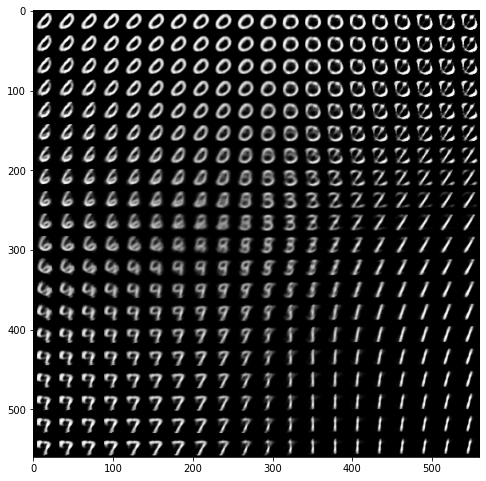

In [ ]:
# Testing
# Generator takes noise as input
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
# Rebuild the decoder to create image from noise
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.relu(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

# Building a manifold of generated digits
n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

<h1>Q1 Using **GPU** </h1>

Step 1, Loss: 249.533813
Step 1000, Loss: 46.827553
Step 2000, Loss: 45.874405
Step 3000, Loss: 44.098644
Step 4000, Loss: 44.003437
Step 5000, Loss: 42.423561
Step 6000, Loss: 40.928410
Step 7000, Loss: 41.985580
Step 8000, Loss: 42.605621
Step 9000, Loss: 43.384979
Step 10000, Loss: 38.534336
time cost 22.448995351791382 s


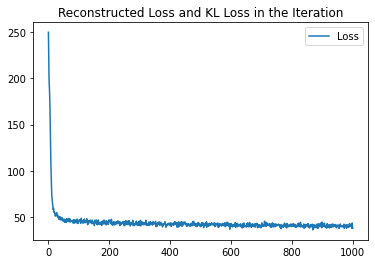

In [20]:
import time

time_start=time.time()

loss_list = []

sess = tf.Session()

sess.run(init)

# Training
for i in range(1, num_steps+1):
    # 取样本 (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # 训练
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 10 == 0 or i ==1:
      loss_list.append(l)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))
time_end=time.time()
plt.plot(loss_list,label = 'Loss')
plt.title( 'Reconstructed Loss and KL Loss in the Iteration')
plt.legend()
print('time cost',time_end-time_start,'s')

<h2>对比未使用 **GPU** 使用了GPU明显速度加快，运行VAE只需要21s</h2>

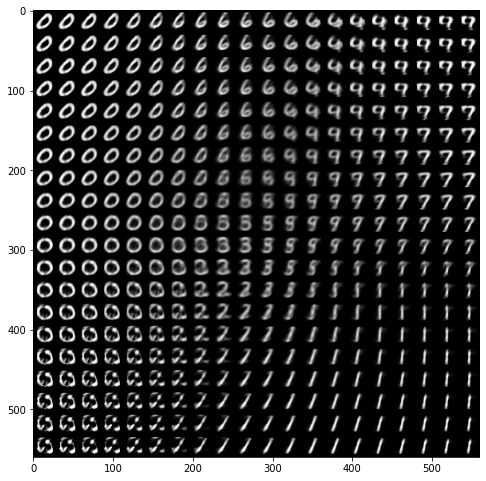

In [ ]:
# Testing
# Generator takes noise as input
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
# Rebuild the decoder to create image from noise
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.relu(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

# Building a manifold of generated digits
n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
        x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

<h1>Q2</h1>

In [ ]:
import pandas as pd
import tensorflow as tf
from pandas import read_csv
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN


def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

'''
异常值处理
'''
dataset = read_csv('PRSA_data_2010.1.1-2014.12.31.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]

'''
从数据到数据集构建
'''
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 输入序列构建
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('value%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # 输出序列构建
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('value%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('value%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # 数据拼接
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 异常值处理
    if dropnan:
        agg.dropna(inplace=True)
    return agg

values = dataset.values
# 标签one hot化
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values = values.astype('float32')
# 归一化特征
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据集构建
reframed = series_to_supervised(scaled, 2, 1)
# 去除当前时刻的天气数据
reframed.drop(reframed.columns[[17,18,19,20,21,22,23]], axis=1, inplace=True)
reframed.to_csv('dataset.csv')
print(reframed.head())

'''
数据集划分，使用前三年的数据训练，其他的数据测试
'''
values = reframed.values
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 数据格式 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



   value1(t-2)  value2(t-2)  value3(t-2)  ...  value7(t-1)  value8(t-1)  value1(t)
2     0.129779     0.352941     0.245902  ...     0.000000          0.0   0.159960
3     0.148893     0.367647     0.245902  ...     0.000000          0.0   0.182093
4     0.159960     0.426471     0.229508  ...     0.037037          0.0   0.138833
5     0.182093     0.485294     0.229508  ...     0.074074          0.0   0.109658
6     0.138833     0.485294     0.229508  ...     0.111111          0.0   0.105634

[5 rows x 17 columns]
(26280, 1, 16) (26280,) (17518, 1, 16) (17518,)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1, 100)            11700     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              101       
Total params: 11,801
Trainable params: 11,801
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
365/365 [==============================] - 1s 2ms/step - loss: 0.0576 - accuracy: 0.0709 - val_loss: 0.0524 - val_accuracy: 0.0103
Epoch 2/50
365/365 [==============================] - 1s 2ms/step - loss: 0.0372 - accuracy: 0.0709 - val_loss: 0.0247 - val_accuracy: 0.0103
Epoch 3/50
365/365 [==============================] - 1s 2ms/step - loss: 0.0186 - accuracy: 0.0709 - val_loss: 0.0172 - val_accuracy: 0.0103
Epoch 4/50
365/365 [==============================] - 1s 2ms/step - loss: 0.0163 

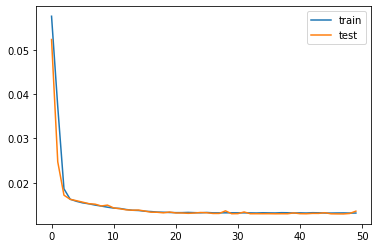

In [ ]:

'''
模型构建
'''


model = Sequential()
model.add(SimpleRNN(units=100, activation='softmax', return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
print(model.summary())
# 训练模型

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1 )
# 对损失进行可视化
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


pred: 63.388096  | real: 61.0
pred: 71.45156  | real: 59.0
Test RMSE: 26.913


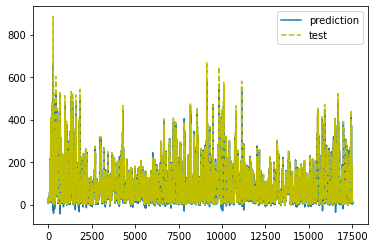

In [ ]:
idx=np.random.randint(0,len(test_X)-1)
# 对测试集进行预测
y_scale = model.predict(test_X[:,:])
y_scale = y_scale.reshape((len(y_scale),1))
test_X_scale = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# 对预测值进行逆标准处理
inv_ypre = np.concatenate((y_scale, test_X_scale[:, 9:]), axis=1)
inv_ypre = scaler.inverse_transform(inv_ypre)[:,0]
# 对测试集标签进行逆标准化处理
inv_ytest = test_y[:,].reshape((len(test_y[:,]), 1))
inv_ytest = np.concatenate((inv_ytest, test_X_scale[:, 9:]), axis=1)
inv_ytest = scaler.inverse_transform(inv_ytest)[:,0]
i = np.random.randint(0,len(test_X)-1)
j = np.random.randint(0,len(test_X)-1)
print("pred:",inv_ypre[i]," | real:",inv_ytest[i])
print("pred:",inv_ypre[j]," | real:",inv_ytest[j])
# 计算 RMSE
rmse = sqrt(mean_squared_error(inv_ypre, inv_ytest))
print('Test RMSE: %.3f' % rmse)
plt.plot(inv_ypre,label = 'prediction')
plt.plot(inv_ytest,'--y' ,label = 'test')
plt.legend()
plt.show()